In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

base_dir = '/content/drive/MyDrive/AI_Waste_Classification'
raw_dir = os.path.join(base_dir, 'dataset_raw')

print("Base directory contents:")
print(os.listdir(base_dir))

print("\nDataset (dataset_raw) contents:")
print(os.listdir(raw_dir))


Base directory contents:
['dataset_raw', 'dataset_clean', 'notebooks']

Dataset (dataset_raw) contents:
['trash', 'plastic', 'paper', 'metal', 'glass', 'cardboard']


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
IMG_SIZE = (224, 224)
BATCH = 32
VAL_SPLIT = 0.2  # 80% training, 20% validation

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data generator (only rescale)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

# Load images from Drive
train_ds = train_datagen.flow_from_directory(
    raw_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training'
)

val_ds = val_datagen.flow_from_directory(
    raw_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

# Print class names
print("\nDetected classes:", train_ds.class_indices)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.

Detected classes: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained base model (without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # 6 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Train the model
EPOCHS = 8  # you can increase to 10–12 if you have time

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 1309s 20s/step - accuracy: 0.2494 - loss: 2.0666 - val_accuracy: 0.5109 - val_loss: 1.2957
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 496ms/step - accuracy: 0.4919 - loss: 1.3325 - val_accuracy: 0.5825 - val_loss: 1.0757
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.5659 - loss: 1.1089 - val_accuracy: 0.6421 - val_loss: 0.9510
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.6364 - loss: 0.9572 - val_accuracy: 0.6779 - val_loss: 0.8725
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.6773 - loss: 0.9000 - val_accuracy: 0.6839 - val_loss: 0.8347
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.6946 - loss: 0.8311 - val_accuracy: 0.6799 - val_loss: 0.8081
Epoch 7/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - accuracy: 0.6762 - loss: 0.8132 - val_accuracy: 0.7078 - val_loss: 0.7496
Epoch 8/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 539ms/step - accuracy: 0.7331 - loss: 0.7361 - val_accuracy: 0.

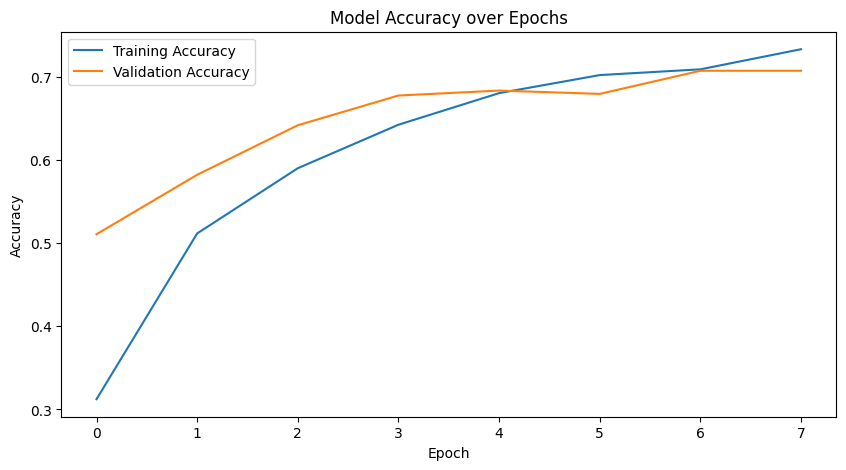

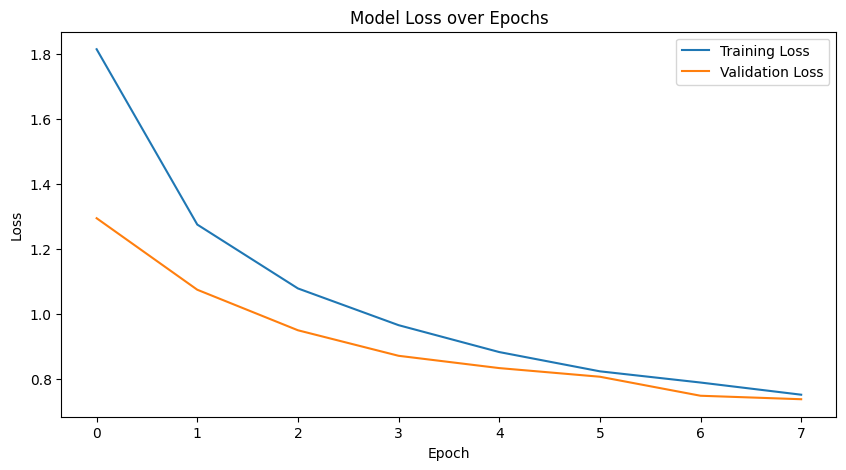

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Extract class labels correctly for ImageDataGenerator
class_names = list(train_ds.class_indices.keys())
print("Class labels:", class_names)


Class labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


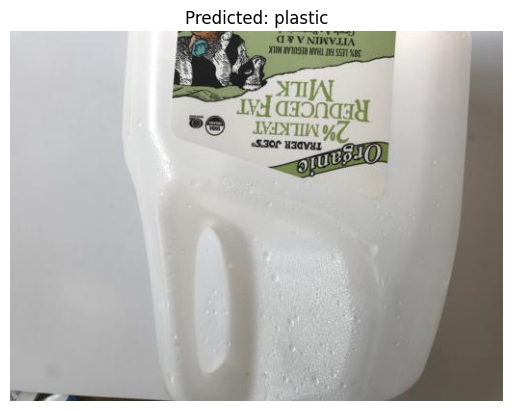

In [10]:
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Pick a random test image from any class folder
test_folder = "/content/drive/MyDrive/AI_Waste_Classification/dataset_raw/plastic"  # 👈 you can change to cardboard, metal, etc.
random_image = random.choice(os.listdir(test_folder))
img_path = os.path.join(test_folder, random_image)

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]

# Display result
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [11]:
# Save your trained model to Google Drive
model.save('/content/drive/MyDrive/AI_Waste_Classification/ai_waste_classification_model.h5')

print("✅ Model saved successfully in Google Drive!")


✅ Model saved successfully in Google Drive!
